In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.neural_networks.nn_forecast import CNNEMOS
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf, plot_weight_mixture_cnns
from src.climatology.climatology import Climatology
from src.models.emos import BootstrapEmos, LinearEMOS
from src.neural_networks.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier


import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data1, test_data1, ignore = load_cv_data(1, features_names_dict)

train_data2, test_data2, ignore = load_cv_data(2, features_names_dict)

train_data3, test_data3_original, ignore = load_cv_data(3, features_names_dict)

train_data0, test_data0, ignore = load_cv_data(0, features_names_dict)

test_data1 = test_data1.batch(test_data1.cardinality())

test_data2 = test_data2.batch(test_data2.cardinality())

test_data3 = test_data3_original.batch(test_data3_original.cardinality())

test_data0 = test_data0.batch(test_data0.cardinality())

train_data0 = train_data0.batch(train_data0.cardinality())

train_data_load = train_data1.batch(32)

train_data1 = train_data1.batch(train_data1.cardinality())

train_data2 = train_data2.batch(train_data2.cardinality())

train_data3 = train_data3.batch(train_data3.cardinality())

In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_3'

filepath2 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    emos_base = LinearEMOS(pickle.load(f))

with open(filepath2, 'rb') as f:
    emos_weight = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [5]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_tn_3'

with open(filepath, 'rb') as f:
    emos165 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_3'

with open(filepath, 'rb') as f:
    emos24 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_ln_3'

with open(filepath, 'rb') as f:
    emos66 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/pareto_front_82_3'

with open(filepath, 'rb') as f:
    emos82 = LinearEMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Log Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [6]:
best_models = {'Intermediate': emos165, 'Extreme': emos82}

model_climatology = {'Intermediate': emos165, 'Extreme': emos82, 'Base Emos': emos_base}

In [7]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [8]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

us1 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_1', train_data_load)

us2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_2', train_data_load)

us3 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_3', train_data_load)

us4 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_4', train_data_load)

us5 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_us_fixed_seed_5', train_data_load)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

is1 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_1', train_data_load)

is2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_2', train_data_load)

is3 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_3', train_data_load)

is4 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_4', train_data_load)

is5 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_fixed_seed_5', train_data_load)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


In [10]:
is_us_models = {
    'is1': is1,
    'is2': is2,
    'is3': is3,
    'is4': is4,
    'is5': is5,
    'us1': us1,
    'us2': us2,
    'us3': us3,
    'us4': us4,
    'us5': us5
}

In [32]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_cnn/'

study = optuna.load_study(study_name='hyperoptCNN_large_space_log_l2', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_2600384/1889573317.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [2]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_cnn/'

study = optuna.load_study(study_name='hyperoptCNN_variable_filters_correct', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_3135573/3406910847.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [33]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_cnn/'

study_small = optuna.load_study(study_name='hyperoptCNN_small_space_444', storage=f'sqlite:///{filepath}/study.db')
study_small.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_2600384/856509195.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study_small.set_metric_names(['CRPS', 'twCRPS12'])


In [34]:
df = study.trials_dataframe()

new_columns_names = {
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_Batch Size': 'Batch Size',
    'params_Forecast Distribution': 'Forecast Distribution',
    'params_L2 Regularization': 'L2 Regularization',
    'params_Learning Rate': 'Learning Rate',
    'params_Number of Layers': 'Number of Layers',
    'params_Number of Units per Layer': 'Number of Units per Layer',
    'params_Optimizer': 'Optimizer',
    'params_cf constant': 'cf constant',
    'params_cf mean': 'cf mean',
    'params_cf std': 'cf std',
    'user_attrs_Average Epochs': 'Average Epochs'
}

df.rename(columns=new_columns_names, inplace=True)

df_small = study_small.trials_dataframe()

new_columns_names = {
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_Batch Size': 'Batch Size',
    'params_Forecast Distribution': 'Forecast Distribution',
    'params_L2 Regularization': 'L2 Regularization',
    'params_Learning Rate': 'Learning Rate',
    'params_Number of Layers': 'Number of Layers',
    'params_Number of Units per Layer': 'Number of Units per Layer',
    'params_Optimizer': 'Optimizer',
    'params_cf constant': 'cf constant',
    'params_cf mean': 'cf mean',
    'params_cf std': 'cf std',
    'user_attrs_Average Epochs': 'Average Epochs'
}

df_small.rename(columns=new_columns_names, inplace=True)


In [35]:
length = 12
top_CRPS = df.sort_values('CRPS').head(length)
top_twCRPS12 = df.sort_values('twCRPS12').head(length)

length = 12
top_CRPS_small = df_small.sort_values('CRPS').head(length)
top_twCRPS12_small = df_small.sort_values('twCRPS12').head(length)

In [36]:
pareto_front = study.best_trials
best_runs = [trial.number for trial in pareto_front]

pareto_trials = df['number'].isin(best_runs)

my_run = df[pareto_trials]

my_run = my_run.sort_values('CRPS')

pareto_front_small = study_small.best_trials
best_runs_small = [trial.number for trial in pareto_front_small]

pareto_trials_small = df_small['number'].isin(best_runs_small)

my_run_small = df_small[pareto_trials_small]

my_run_small = my_run_small.sort_values('CRPS')

In [37]:
params = [
    'Average Epochs',
'Batch Size',
'L2 Regularization',
'Optimizer',
'Learning Rate',
 'Number of Layers',
 'Number of Units per Layer',
'Forecast Distribution',
'cf mean',
'cf std',
'cf constant',
 'CRPS',
'twCRPS12',
]

In [38]:
params2 = [
    'Average Epochs',
'cf mean',
'cf std',
'cf constant',
 'CRPS',
'twCRPS12',
]

In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

model_115_3 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_3', train_data_load)

model_115_3_v2 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_3_v2', train_data_load)

model_115_3_v3 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_3_v3', train_data_load)

model_115_2 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_2', train_data_load)

model_115_1 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_1', train_data_load)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


In [26]:
model_115_3_twcrps = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_100run_115_fold_3_twcrps', train_data_load)

model_115_3_twcrps_v2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_100run_115_fold_3_twcrps_v2', train_data_load)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


In [58]:
model_115_complex_crps = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_3_complex', train_data_load)

model_115_complex_crps_2 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_100run_115_fold_3_complex_v2', train_data_load)

model_115_complex_twcrps = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_130run_115_fold_3_complex', train_data_load)

model_115_complex_twcrps_2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_130run_115_fold_3_complex_v2', train_data_load)

complex_models_dict = {
    'CRPS': model_115_complex_crps,
    'CRPS 2': model_115_complex_crps_2,
    'twCRPS': model_115_complex_twcrps,
    'twCRPS 2': model_115_complex_twcrps_2
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 178 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


In [24]:
model_115_simple_crps = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_120run_115_fold_3_simple', train_data_load)

model_115_simple_crps_v2 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_120run_115_fold_3_simple_v2', train_data_load)

model_115_simple_twcrps = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_120run_115_fold_3_simple', train_data_load)

model_115_simple_twcrps_v2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_120run_115_fold_3_simple_v2', train_data_load)

simple_models_dict = {'CRPS': model_115_simple_crps,
                      'CRPS 2': model_115_simple_crps_v2,
                      'twCRPS': model_115_simple_twcrps,
                      'twCRPS 2': model_115_simple_twcrps_v2}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

model_115_verysimple_crps = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_130run_115_fold_3_very_simple', train_data_load)

model_115_verysimple_crps_v2 = CNNEMOS.my_load(filepath + 'CRPS_mixture_epochs_130run_115_fold_3_very_simple_v2', train_data_load)

model_115_verysimple_twcrps = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_130run_115_fold_3_very_simple', train_data_load)

model_115_verysimple_twcrps_v2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_mixture_epochs_130run_115_fold_3_very_simple_v2', train_data_load)

verysimple_models_dict = {'CRPS': model_115_verysimple_crps,
                      'CRPS 2': model_115_verysimple_crps_v2,
                      'twCRPS': model_115_verysimple_twcrps,
                      'twCRPS 2': model_115_verysimple_twcrps_v2}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'nn_conv_model_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'nn_conv_model_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'nn_conv_model_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'nn_conv_model_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [50]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

best_cnn = CNNEMOS.my_load(filepath + 'twCRPS_mean_5.934686_std_9.369574_constant_0.997574_mixture_epochs_100run_115_fold_3_weird', train_data_load)

best_cnn_2 = CNNEMOS.my_load(filepath + 'twCRPS_mean_5.934686_std_9.369574_constant_0.997574_mixture_epochs_100run_115_fold_3_weird_v2', train_data_load)

best_cnn_dict_comparison = {
    'CRPS': model_115_3,
    'CRPS 2': model_115_3_v2,
    'twCRPS': best_cnn,
    'twCRPS 2': best_cnn_2
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


In [11]:
model_115_dict_3 = {"model": model_115_3}

model_115_dict_3_v2 = {"model": model_115_3_v2}

model_115_dict_3_v3 = {"model": model_115_3_v3}

model_115_dict_2 = {"model": model_115_2}

model_115_dict_1 = {"model": model_115_1}

In [27]:
model_115_dict_comparison = {'CRPS': model_115_3, 
                             'CRPS 2': model_115_3_v2,
                             'twCRPS': model_115_3_twcrps,
                             'twCRPS 2': model_115_3_twcrps_v2}

## Work of the past weeks

- Looked at how the constraint for the linear EMOS with variable weight parameter is implemented.

- Checked Daniel's code for climatology.

- Fixed initialization ....

- Results for optimizing CNNs.

One remark, Daniel changed the coordinates of 3 stations. I have not done this, is that a problem?

### Constraint for Mixture Linear Model

For the mixture linear I defined the weight by 

$w = \sigma(\alpha + \beta X_w)$

where $\sigma$ is the sigmoid function. I now set the following contraints:

$\alpha \in [4,12] \quad\text{and} \quad\beta \in [-6,-0.6]$

The constraint is implemented with projection.

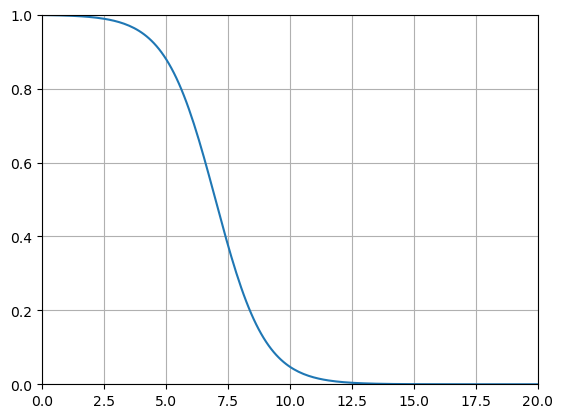

In [11]:
alpha = 7
beta = -1
x = np.linspace(0, 20, 200)

y = 1 / (1 + np.exp(-(alpha + beta * x)))
plt.plot(x, y)
plt.xlim(0,20)
plt.ylim(0,1)
plt.grid()
plt.show()

### Climatology for low wind speeds

In the plots of Daniel, he starts at 1 instead of 0.

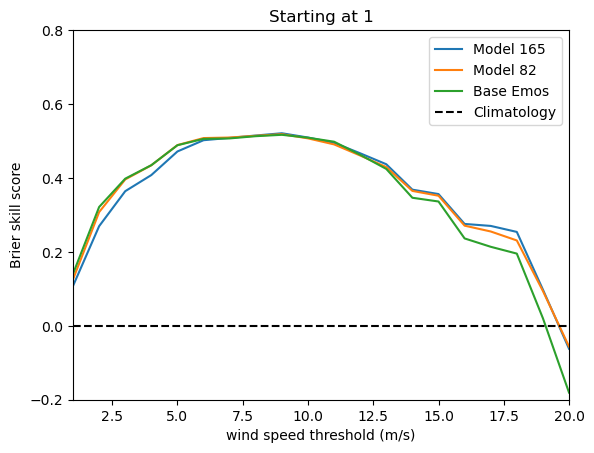

In [12]:
title = 'Starting at 1'
ylim = [-0.2, 0.8]
values = np.arange(1, 21, 1)
make_brier_skill_plot_tf(climatology, model_climatology, test_data3, values, name_base_model='Climatology', ylim=ylim, title=title)

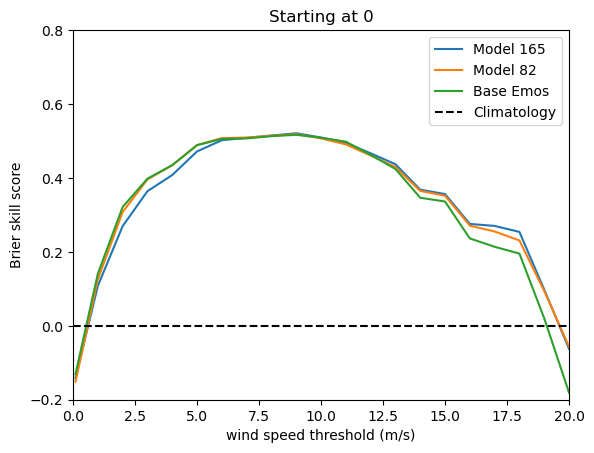

In [13]:
title = 'Starting at 0'
ylim = [-0.2, 0.8]
values = np.arange(0.0,21.0,1.0)
values[0] = 0.1
make_brier_skill_plot_tf(climatology, model_climatology, test_data3, values, name_base_model='Climatology', ylim=ylim, title=title)

### Fixed Initialization

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


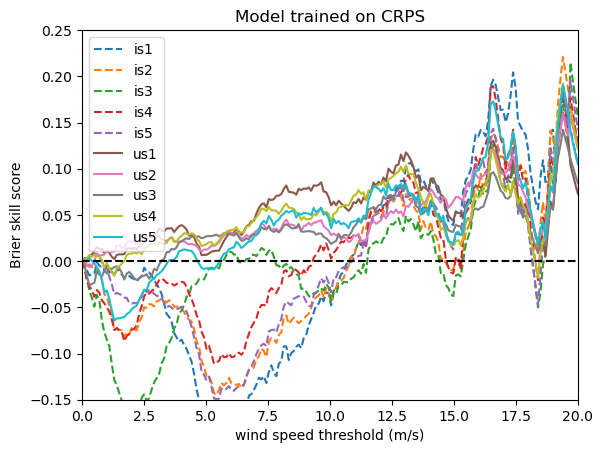

In [14]:
values = np.linspace(0, 20, 200)

brier_base_model = emos_base.Brier_Score(test_data3, values)
for model in is_us_models:
    brier_scores = is_us_models[model].Brier_Score(test_data3, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if model[:2] == 'us':
        plt.plot(values, brier_skill_scores, label = model)
    else:
        plt.plot(values, brier_skill_scores, label = model, linestyle='--')

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('wind speed threshold (m/s)')
plt.ylabel('Brier skill score')
plt.xlim(0, 20)
plt.ylim(-0.15, 0.25)
plt.title("Model trained on CRPS")
plt.legend()
plt.show()

### Results Hyperparameter Optimization CNNs

Search Space:
- Batch Size: $\{16,32,64,128,256,512, 1024\}$

- $l_2$ Regularization: $[0.00005, 0.1]$

- Optimizer: Adam or SGD

- Learning Rate: $[0.0001, 0.03]$

- Number of Layers: $\{1,2,3,4,5\}$

- Number of Units per Layer: $\{10,20,...,200\}$

- Forecast Distribution: TN, LN or Mixture of TN-LN

- cf mean: $[-5,15]$

- cf std: $[0.0001, 10]$

- cf constant: $[0, 1]$

In total we performed 118 trials. For every fold, we trained 2 models, meaning that per setting we trained 6 models in total. Early stopping was used with a patience of 10 epochs.

In [28]:
display(top_CRPS[params])

,Average Epochs,Batch Size,L2 Regularization,Optimizer,Learning Rate,Number of Layers,Number of Units per Layer,Forecast Distribution,cf mean,cf std,cf constant,CRPS,twCRPS12
115,59.833333,64,0.031658,adam,0.000105,2,170,distr_mixture,-3.898916,0.000415,0.186185,0.825659,0.055649
116,75.000000,64,0.034923,adam,0.000120,3,160,distr_mixture,-0.868136,0.000420,0.081623,0.828270,0.056028
96,49.666667,32,0.001319,sgd,0.001818,1,170,distr_mixture,-4.013118,0.000364,0.908079,0.829541,0.056131
60,55.166667,32,0.000944,sgd,0.003822,1,180,distr_mixture,4.076166,0.006215,0.962587,0.832793,0.056324
114,26.333333,64,0.021982,adam,0.001453,2,160,distr_mixture,-4.530345,0.000111,0.864461,0.832976,0.056029
33,28.166667,32,0.002730,sgd,0.023165,1,170,distr_mixture,2.031473,0.100920,0.851836,0.833142,0.055977
90,41.333333,32,0.000566,sgd,0.005256,1,160,distr_mixture,3.821750,0.000902,0.991248,0.833565,0.056266
38,28.166667,32,0.003672,sgd,0.024505,1,160,distr_mixture,1.849459,0.058626,0.864038,0.833572,0.056432
24,39.166667,32,0.002821,sgd,0.024464,2,130,distr_mixture,0.944733,9.322542,0.264916,0.833588,0.056406
36,29.000000,32,0.003666,sgd,0.025045,1,170,distr_trunc_normal,14.977879,0.246024,0.998625,0.834048,0.056404


In [29]:
display(top_twCRPS12[params])

,Average Epochs,Batch Size,L2 Regularization,Optimizer,Learning Rate,Number of Layers,Number of Units per Layer,Forecast Distribution,cf mean,cf std,cf constant,CRPS,twCRPS12
115,59.833333,64,0.031658,adam,0.000105,2,170,distr_mixture,-3.898916,0.000415,0.186185,0.825659,0.055649
98,31.000000,128,0.000821,adam,0.001849,3,70,distr_trunc_normal,-3.955865,0.000140,0.318022,0.840325,0.055911
32,23.666667,32,0.002635,sgd,0.022092,1,170,distr_mixture,1.171840,3.852197,0.855104,0.837623,0.055920
83,38.833333,32,0.001522,sgd,0.023375,1,160,distr_mixture,14.069652,0.075488,0.905570,0.834303,0.055922
33,28.166667,32,0.002730,sgd,0.023165,1,170,distr_mixture,2.031473,0.100920,0.851836,0.833142,0.055977
116,75.000000,64,0.034923,adam,0.000120,3,160,distr_mixture,-0.868136,0.000420,0.081623,0.828270,0.056028
114,26.333333,64,0.021982,adam,0.001453,2,160,distr_mixture,-4.530345,0.000111,0.864461,0.832976,0.056029
50,36.000000,32,0.055677,sgd,0.015654,1,150,distr_trunc_normal,-0.804026,0.959547,0.675059,0.834650,0.056046
112,44.000000,16,0.001990,sgd,0.005347,2,100,distr_mixture,-2.818463,0.000806,0.813046,0.837247,0.056127
96,49.666667,32,0.001319,sgd,0.001818,1,170,distr_mixture,-4.013118,0.000364,0.908079,0.829541,0.056131


In [30]:
display(my_run[params])

,Average Epochs,Batch Size,L2 Regularization,Optimizer,Learning Rate,Number of Layers,Number of Units per Layer,Forecast Distribution,cf mean,cf std,cf constant,CRPS,twCRPS12
115,59.833333,64,0.031658,adam,0.000105,2,170,distr_mixture,-3.898916,0.000415,0.186185,0.825659,0.055649


I then fixed all the parameters except for the parameters in the weight function, and did another round of hyperparameter optimization. This gave these results.

In [41]:
display(top_CRPS_small[params2])

,Average Epochs,cf mean,cf std,cf constant,CRPS,twCRPS12
49,48.333333,1.033092,4.456436,0.997382,0.823186,0.055287
33,30.000000,5.934686,9.369574,0.997574,0.823940,0.055207
40,61.333333,-0.770368,1.445118,0.837672,0.824272,0.055433
36,44.833333,2.206306,3.579858,0.875382,0.824364,0.055667
29,70.666667,-0.818025,0.001353,0.324473,0.824717,0.055406
34,56.833333,4.893108,7.301722,0.996173,0.824825,0.055409
23,73.833333,-4.097736,0.000183,0.367532,0.825042,0.055989
0,67.500000,0.429097,0.000130,0.250924,0.825413,0.056082
1,67.500000,-0.210503,0.958430,0.293237,0.825567,0.056111
45,62.833333,5.493173,5.443629,0.864578,0.825594,0.055265


In [42]:
display(top_twCRPS12_small[params2])

,Average Epochs,cf mean,cf std,cf constant,CRPS,twCRPS12
33,30.000000,5.934686,9.369574,0.997574,0.823940,0.055207
45,62.833333,5.493173,5.443629,0.864578,0.825594,0.055265
49,48.333333,1.033092,4.456436,0.997382,0.823186,0.055287
7,35.666667,7.637882,0.132999,0.767333,0.831321,0.055331
50,58.666667,1.043101,5.433051,0.936747,0.826826,0.055338
43,41.000000,5.860291,1.278010,0.841591,0.828269,0.055374
29,70.666667,-0.818025,0.001353,0.324473,0.824717,0.055406
34,56.833333,4.893108,7.301722,0.996173,0.824825,0.055409
24,76.333333,-2.539084,0.000309,0.345053,0.825678,0.055422
40,61.333333,-0.770368,1.445118,0.837672,0.824272,0.055433


In [43]:
display(my_run_small[params2])

,Average Epochs,cf mean,cf std,cf constant,CRPS,twCRPS12
49,48.333333,1.033092,4.456436,0.997382,0.823186,0.055287
33,30.000000,5.934686,9.369574,0.997574,0.823940,0.055207


These results are not that interesting. The difference in performance between training on the CRPS and twCRPS is neglegible, which is shown in the following plot. The architecture of the CNN is the same for all models, and for the twCRPS the models have the weight function from trial 33.

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


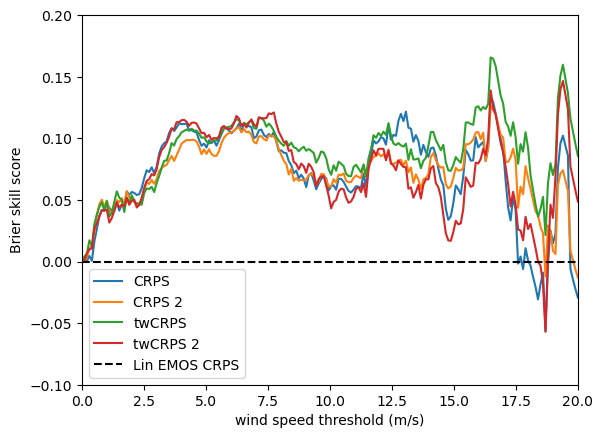

In [51]:
values = np.linspace(0, 20, 200)
make_brier_skill_plot_tf(emos_base, best_cnn_dict_comparison, test_data3, values, ylim=[-0.1, 0.2], name_base_model='Lin EMOS CRPS')

### Comparing performance on different architecutres

The models that are trained on the twCRPS use weight function with $c = 0.01, \sigma = 0.25, \mu = 9$. (This is the same weight function as the 'extreme' linear EMOS model)

For the simpler models, we have one 7x7 conv block (instead of 4), one 5x5 conv block (instead of 4), one 3x3 conv block (instead of 4) and 1 dense layer with 50 units (instead of 2 with 170 units).

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


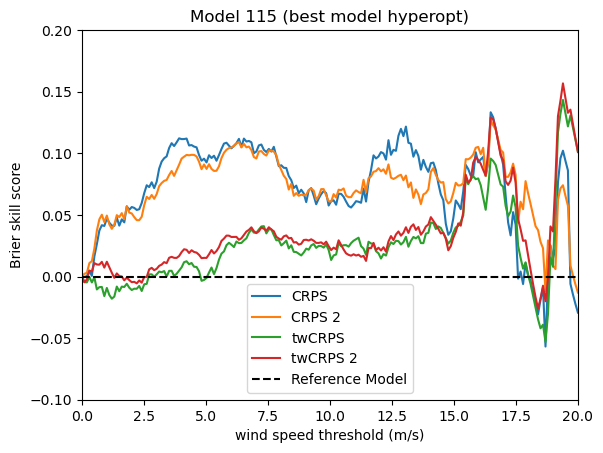

In [28]:
values = np.linspace(0, 20, 200)
make_brier_skill_plot_tf(emos_base, model_115_dict_comparison, test_data3, values, ylim=[-0.1, 0.2], title='Model 115 (best model hyperopt CNN)', name_base_model='Lin EMOS CRPS')

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


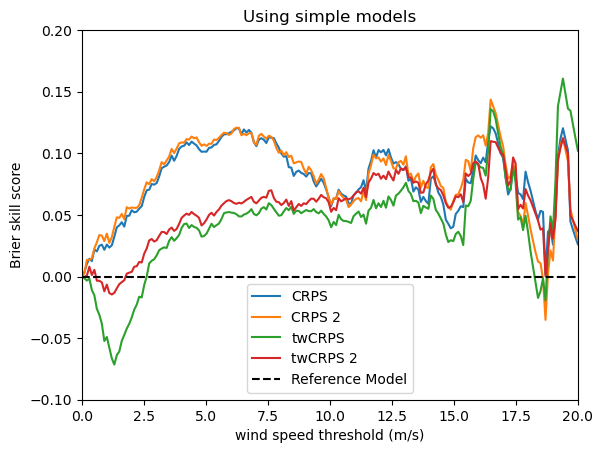

In [25]:
values = np.linspace(0, 20, 200)
make_brier_skill_plot_tf(emos_base, simple_models_dict, test_data3, values, ylim=[-0.1, 0.2], title='Using simple CNN models', name_base_model='Lin EMOS CRPS')

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


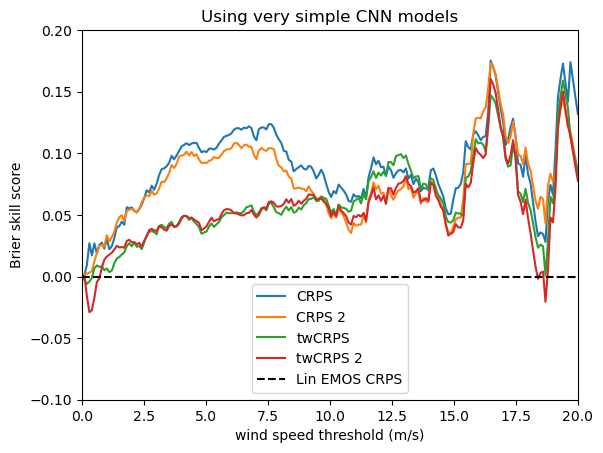

In [13]:
values = np.linspace(0, 20, 200)
make_brier_skill_plot_tf(emos_base, verysimple_models_dict, test_data3, values, ylim=[-0.1, 0.2], title='Using very simple CNN models', name_base_model='Lin EMOS CRPS')

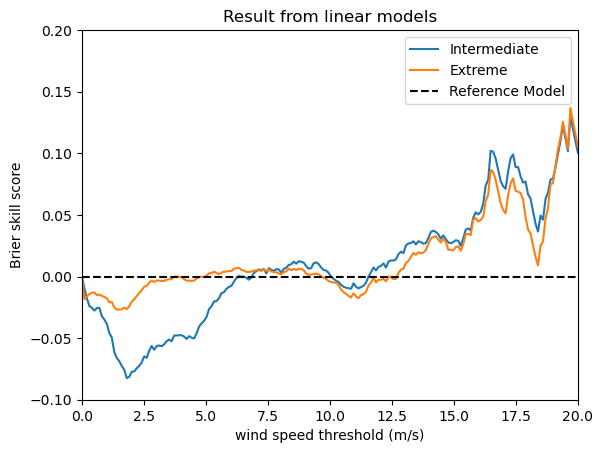

In [30]:
values = np.linspace(0, 20, 200)
make_brier_skill_plot_tf(emos_base, best_models, test_data3, values, ylim=[-0.1, 0.2], title='Result from linear models')

### Choice of Distribution

The best model had a mixture distribution. In these plots we can see the weight for the TN for the observations in the test data. Unfortanetely, it still does not have consistent behavior. I think that this is because of the sample based approach. 

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


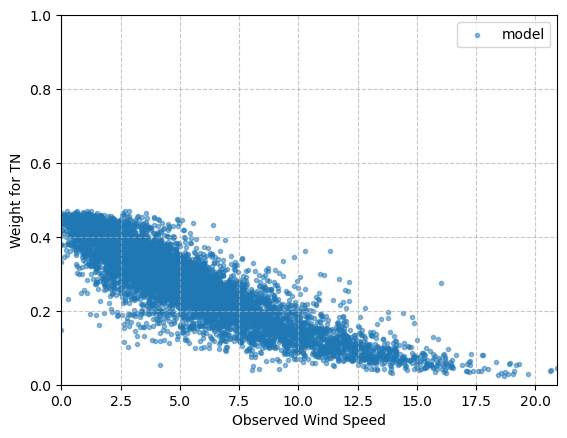

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
0.81708205


In [64]:
plot_weight_mixture_cnns(model_115_dict_3_v3, test_data3)


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


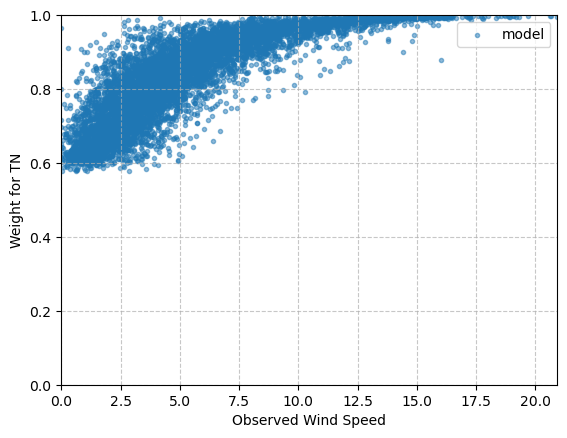

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
0.8181586


In [65]:
plot_weight_mixture_cnns(model_115_dict_3_v2, test_data3)


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


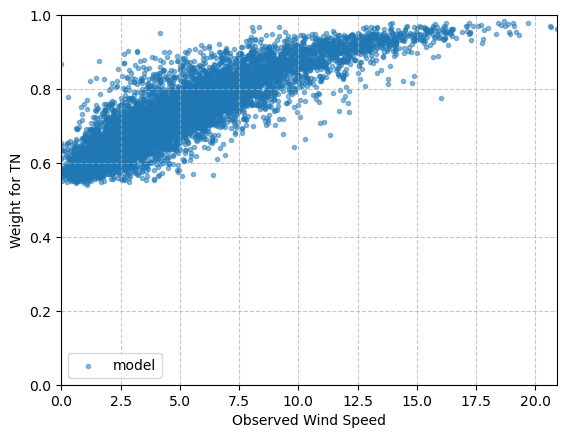

In [63]:
plot_weight_mixture_cnns(model_115_dict_3, test_data3)

In [68]:
X_dict, y = next(iter(train_data3))

In [69]:
X_nwp_pred = X_dict["wind_speed_forecast"]

In the following plot we see the difference between the observed wind speed and predicted wind speed for different ranges. (In case the error is positive, this means that the observation is greater than the prediction)

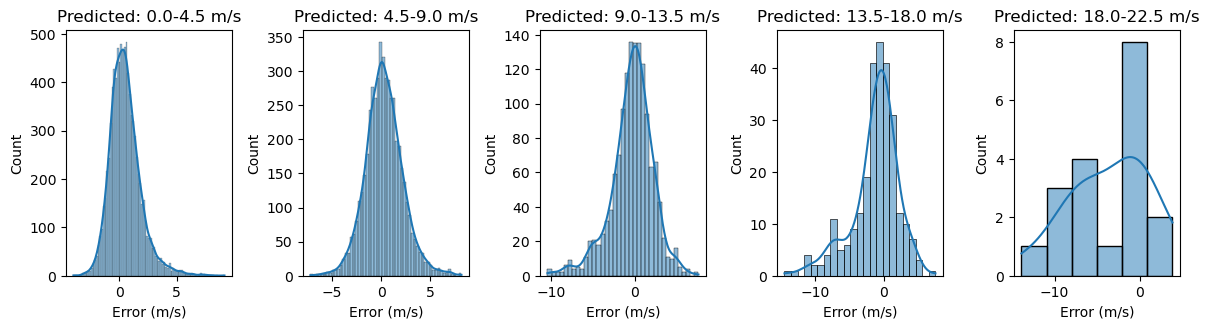

In [70]:
import seaborn as sns

# Calculate the errors
errors = y - X_nwp_pred

# Plot histograms of errors for different ranges of predicted wind speeds
bins = np.linspace(0, 22.5, 6)
bin_indices = np.digitize(X_nwp_pred, bins)

plt.figure(figsize=(12, 6))
for i in range(1, len(bins)):
    plt.subplot(2, 5, i)
    sns.histplot(errors[bin_indices == i], kde=True)
    plt.title(f'Predicted: {bins[i-1]:.1f}-{bins[i]:.1f} m/s')
    plt.xlabel('Error (m/s)')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Work for the coming weeks

- Further testing of CNNs? I don't think the results will change significantly.

- Start using the test set to produce final results?

- Work on writing the thesis.

- Further cleaning the code.
